In [48]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "../utils/")
from data_loader import load_data
from scipy.stats import ttest_ind 
from scipy.stats import f_oneway
import pathlib

In [49]:
latent_df = pd.read_parquet("../2.train-VAE/results/latent_df.parquet")
metadata_df = pd.read_parquet(".././0.data-download/data/metadata_df.parquet")
data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")
gsea_results_df = pd.read_parquet("../3.analysis/results/combined_gsea_results.parquet.gz")
all_GSEA_results_df = pd.read_parquet("../3.analysis/results/all_gsea_results.parquet.gz")
significant_gsea_df = pd.read_parquet("../3.analysis/results/significant_gsea_results.parquet.gz")

In [50]:
# Creating categorized lists of sample IDs used in BVAE training
# note that 10 of the 912 used samples have Unknown Sex

ped_ids = metadata_df.query("AgeCategory == 'Pediatric'").ModelID.tolist()
adult_ids = metadata_df.query("AgeCategory == 'Adult'").ModelID.tolist()
male_ids = metadata_df.query("Sex == 'Male'").ModelID.tolist()
female_ids = metadata_df.query("Sex == 'Female'").ModelID.tolist()
ped_male_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Male'").ModelID.tolist()
adult_male_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Male'").ModelID.tolist()
ped_female_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Female'").ModelID.tolist()
adult_female_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Female'").ModelID.tolist()

In [51]:
# Generating latent dataframes for each category and dropping the id column to prep for t tests
def generate_latent_df(latent_df, category_ids):
    """
    Generate a latent DataFrame filtered by category IDs and drop the 'ModelID' column.

    Parameters:
    latent_df (pd.DataFrame): The original DataFrame containing latent variables.
    category_ids (list): The list of ModelIDs to filter the DataFrame by.

    Returns:
    pd.DataFrame: The filtered DataFrame with the 'ModelID' column dropped.
    """
    filtered_df = latent_df[latent_df['ModelID'].isin(category_ids)].copy()
    filtered_df_float = filtered_df.drop(columns=["ModelID"])
    filtered_df_float.reset_index(drop=True, inplace=True)
    return filtered_df, filtered_df_float


# Usage for each category
adult_latent_df, adult_latent_df_float = generate_latent_df(latent_df, adult_ids)
ped_latent_df, ped_latent_df_float = generate_latent_df(latent_df, ped_ids)
male_latent_df, male_latent_df_float = generate_latent_df(latent_df, male_ids)
female_latent_df, female_latent_df_float = generate_latent_df(latent_df, female_ids)
ped_male_latent_df, ped_male_latent_df_float = generate_latent_df(latent_df, ped_male_ids)
adult_male_latent_df, adult_male_latent_df_float = generate_latent_df(latent_df, adult_male_ids)
ped_female_latent_df, ped_female_latent_df_float = generate_latent_df(latent_df, ped_female_ids)
adult_female_latent_df, adult_female_latent_df_float = generate_latent_df(latent_df, adult_female_ids)

In [52]:
# t tests comparing adult vs ped for each latent dimension

t_test_adult_vs_ped = ttest_ind(adult_latent_df_float, ped_latent_df_float)
t_test_adult_vs_ped = pd.DataFrame(t_test_adult_vs_ped).T
t_test_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
t_test_adult_vs_ped['latent_feature'] = t_test_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_adult_vs_ped = t_test_adult_vs_ped.dropna()
print(t_test_adult_vs_ped.shape)

t_test_adult_vs_ped.head(50)

(83, 4)


,t_stat,p_value,comparison,latent_feature
1,9.150640,3.338656e-19,Adult vs Pediatric,2
2,4.986400,7.302761e-07,Adult vs Pediatric,3
5,-1.081427,2.797798e-01,Adult vs Pediatric,6
7,-1.369962,1.710205e-01,Adult vs Pediatric,8
8,2.674900,7.602813e-03,Adult vs Pediatric,9
9,-3.202849,1.405729e-03,Adult vs Pediatric,10
10,0.418699,6.755301e-01,Adult vs Pediatric,11
11,2.022341,4.341918e-02,Adult vs Pediatric,12
12,0.418699,6.755301e-01,Adult vs Pediatric,13
13,1.196462,2.318129e-01,Adult vs Pediatric,14


In [53]:
# t tests comparing male vs female for each latent dimension

t_test_male_vs_female = ttest_ind(male_latent_df_float, female_latent_df_float)
t_test_male_vs_female = pd.DataFrame(t_test_male_vs_female).T
t_test_male_vs_female.columns = ["t_stat", "p_value"]
t_test_male_vs_female['comparison'] = 'Male vs Female'
t_test_male_vs_female['latent_feature'] = t_test_male_vs_female.index + 1
# Remove rows with NaN values
t_test_male_vs_female = t_test_male_vs_female.dropna()
print(t_test_male_vs_female.shape)

t_test_male_vs_female.head()

(83, 4)


,t_stat,p_value,comparison,latent_feature
1,-1.320005,0.187153,Male vs Female,2
2,1.437352,0.150949,Male vs Female,3
5,1.570923,0.116535,Male vs Female,6
7,1.330104,0.183804,Male vs Female,8
8,0.811411,0.417334,Male vs Female,9


In [54]:
# t tests comparing adult male vs ped male for each latent dimension

t_test_adult_male_vs_ped_male = ttest_ind(ped_male_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_ped_male = pd.DataFrame(t_test_adult_male_vs_ped_male).T
t_test_adult_male_vs_ped_male.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_ped_male['comparison'] = 'Adult Male vs Pediatric Male'
t_test_adult_male_vs_ped_male['latent_feature'] = t_test_adult_male_vs_ped_male.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_ped_male = t_test_adult_male_vs_ped_male.dropna()
print(t_test_adult_male_vs_ped_male.shape)

t_test_adult_male_vs_ped_male.head()

(81, 4)


,t_stat,p_value,comparison,latent_feature
1,-6.875336,1.720136e-11,Adult Male vs Pediatric Male,2
2,-3.993782,7.407305e-05,Adult Male vs Pediatric Male,3
5,-0.010902,9.913056e-01,Adult Male vs Pediatric Male,6
7,0.647287,5.177224e-01,Adult Male vs Pediatric Male,8
8,-1.707413,8.832233e-02,Adult Male vs Pediatric Male,9


In [55]:
# t tests comparing adult female vs ped female for each latent dimension

t_test_adult_female_vs_ped_female = ttest_ind(ped_female_latent_df_float, adult_female_latent_df_float)
t_test_adult_female_vs_ped_female = pd.DataFrame(t_test_adult_female_vs_ped_female).T
t_test_adult_female_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_adult_female_vs_ped_female['comparison'] = 'Adult Female vs Pediatric Female'
t_test_adult_female_vs_ped_female['latent_feature'] = t_test_adult_female_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_adult_female_vs_ped_female = t_test_adult_female_vs_ped_female.dropna()
print(t_test_adult_female_vs_ped_female.shape)

t_test_adult_female_vs_ped_female.head()

(75, 4)


,t_stat,p_value,comparison,latent_feature
1,-5.800089,1.334612e-08,Adult Female vs Pediatric Female,2
2,-2.408502,1.646288e-02,Adult Female vs Pediatric Female,3
5,1.605727,1.091113e-01,Adult Female vs Pediatric Female,6
7,1.290388,1.976503e-01,Adult Female vs Pediatric Female,8
8,-1.920022,5.555547e-02,Adult Female vs Pediatric Female,9


In [56]:
# t tests comparing ped male vs ped female for each latent dimension

t_test_ped_male_vs_ped_female = ttest_ind(ped_female_latent_df_float, ped_male_latent_df_float)
t_test_ped_male_vs_ped_female = pd.DataFrame(t_test_ped_male_vs_ped_female).T
t_test_ped_male_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_ped_male_vs_ped_female['comparison'] = 'Pediatric Male vs Pediatric Female'
t_test_ped_male_vs_ped_female['latent_feature'] = t_test_ped_male_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_ped_male_vs_ped_female = t_test_ped_male_vs_ped_female.dropna()
print(t_test_ped_male_vs_ped_female.shape)

t_test_ped_male_vs_ped_female.head()

(59, 4)


,t_stat,p_value,comparison,latent_feature
1,0.624822,0.533158,Pediatric Male vs Pediatric Female,2
2,0.239519,0.811072,Pediatric Male vs Pediatric Female,3
5,0.618278,0.537450,Pediatric Male vs Pediatric Female,6
7,0.042067,0.966508,Pediatric Male vs Pediatric Female,8
8,-0.665969,0.506584,Pediatric Male vs Pediatric Female,9


In [57]:
# t tests comparing adult male vs adult female for each latent dimension

t_test_adult_male_vs_adult_female = ttest_ind(adult_female_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_adult_female = pd.DataFrame(t_test_adult_male_vs_adult_female).T
t_test_adult_male_vs_adult_female.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_adult_female['comparison'] = 'Adult Male vs Adult Female'
t_test_adult_male_vs_adult_female['latent_feature'] = t_test_adult_male_vs_adult_female.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_adult_female = t_test_adult_male_vs_adult_female.dropna()
print(t_test_adult_male_vs_adult_female.shape)

t_test_adult_male_vs_adult_female.head()

(83, 4)


,t_stat,p_value,comparison,latent_feature
1,1.102306,0.270656,Adult Male vs Adult Female,2
2,-1.689887,0.091434,Adult Male vs Adult Female,3
5,-1.908845,0.056635,Adult Male vs Adult Female,6
7,-1.426477,0.154116,Adult Male vs Adult Female,8
8,-0.688035,0.491628,Adult Male vs Adult Female,9


In [58]:
# Combining and saving t test results
t_test_results_df = pd.concat([
    t_test_adult_vs_ped, 
    t_test_male_vs_female, 
    t_test_adult_male_vs_ped_male, 
    t_test_adult_female_vs_ped_female, 
    t_test_ped_male_vs_ped_female, 
    t_test_adult_male_vs_adult_female
]).reset_index(drop=True)
t_test_results_dir = pathlib.Path("./results/t_test_results.tsv")
t_test_results_df.to_parquet(t_test_results_dir)

# sort to show most significant p-values
t_test_results_df.sort_values(by='p_value', ascending = True)

,t_stat,p_value,comparison,latent_feature
0,9.150640,3.338656e-19,Adult vs Pediatric,2
64,-7.286610,6.647267e-13,Adult vs Pediatric,77
166,-6.875336,1.720136e-11,Adult Male vs Pediatric Male,2
79,-6.788515,1.986295e-11,Adult vs Pediatric,92
33,-6.479085,1.475055e-10,Adult vs Pediatric,42
...,...,...,...,...
101,0.078543,9.374128e-01,Male vs Female,26
399,-0.059312,9.527180e-01,Adult Male vs Adult Female,26
325,0.042067,9.665084e-01,Pediatric Male vs Pediatric Female,8
394,0.039975,9.681232e-01,Adult Male vs Adult Female,19


In [59]:
# ANOVA Testing
f_statistic, p_value = f_oneway(adult_male_latent_df_float, ped_male_latent_df_float, adult_female_latent_df_float, ped_female_latent_df_float)
anova_df = pd.DataFrame({'f_stat': f_statistic.tolist(), 'p_value': p_value.tolist()})
anova_df['latent_feature'] = anova_df.index + 1
# Remove rows with NaN values
anova_df = anova_df.dropna()
anova_df

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:605: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


,f_stat,p_value,latent_feature
1,27.630079,3.943114e-17,2
2,8.065036,2.617401e-05,3
5,1.738019,1.575582e-01,6
7,1.290933,2.761973e-01,8
8,2.346640,7.134171e-02,9
...,...,...,...
90,1.499858,2.130712e-01,91
91,17.133110,7.699898e-11,92
92,7.987702,2.918168e-05,93
93,10.991470,4.250374e-07,94


In [60]:
#Lung Cancer in adult vs Neuroblastoma in ped comparison
NB_ids = model_df.query("OncotreePrimaryDisease == 'Neuroblastoma'").ModelID.tolist()

ped_NB_latent_df = ped_latent_df.copy()
for index, row in ped_NB_latent_df.iterrows():
    if row['ModelID'] not in NB_ids:
        ped_NB_latent_df.drop(index, inplace=True)
ped_NB_latent_float_df = ped_NB_latent_df.drop(columns=["ModelID"])
ped_NB_latent_float_df.reset_index(drop=True, inplace=True)

LC_ids = model_df.query("OncotreePrimaryDisease == 'Non-Small Cell Lung Cancer'").ModelID.tolist()

adult_LC_latent_df = adult_latent_df.copy()
for index, row in adult_LC_latent_df.iterrows():
    if row['ModelID'] not in LC_ids:
        adult_LC_latent_df.drop(index, inplace=True)
adult_LC_latent_float_df = adult_LC_latent_df.drop(columns=["ModelID"])
adult_LC_latent_float_df.reset_index(drop=True, inplace=True)

In [61]:
# t tests comparing Lung Cancer in adult vs Neuroblastoma in ped for each latent dimension

t_test_diff_adult_vs_ped = ttest_ind(adult_LC_latent_float_df, ped_NB_latent_float_df)
t_test_diff_adult_vs_ped = pd.DataFrame(t_test_diff_adult_vs_ped).T
t_test_diff_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_diff_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
t_test_diff_adult_vs_ped['latent_feature'] = t_test_diff_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_diff_adult_vs_ped = t_test_diff_adult_vs_ped.dropna()
print(t_test_diff_adult_vs_ped.shape)

t_test_diff_adult_vs_ped.sort_values(by = 'p_value', ascending= True)

(55, 4)


,t_stat,p_value,comparison,latent_feature
1,10.919178,2.189823e-19,Adult vs Pediatric,2
2,6.144094,1.235557e-08,Adult vs Pediatric,3
76,-5.394814,3.817951e-07,Adult vs Pediatric,77
91,-5.109705,1.324383e-06,Adult vs Pediatric,92
41,-4.774508,5.441563e-06,Adult vs Pediatric,42
89,-4.605003,1.088119e-05,Adult vs Pediatric,90
86,-4.482517,1.778362e-05,Adult vs Pediatric,87
81,-4.393076,2.532530e-05,Adult vs Pediatric,82
27,-4.257864,4.285105e-05,Adult vs Pediatric,28
47,-4.087877,8.177356e-05,Adult vs Pediatric,48


In [62]:
# Obtaining shared cancer types in ped and adult
adult_types = model_df.query("AgeCategory == 'Adult'").OncotreePrimaryDisease.tolist()
adult_types = [x for x in adult_types if adult_types.count(x) >= 5]
adult_types = list(set(adult_types))

ped_types = model_df.query("AgeCategory == 'Pediatric'").OncotreePrimaryDisease.tolist()
ped_types = [x for x in ped_types if ped_types.count(x) >= 5]
ped_types = list(set(ped_types))

shared_types = set(adult_types) & set(ped_types)
shared_types

{'Acute Myeloid Leukemia', 'Ewing Sarcoma', 'Mature B-Cell Neoplasms'}

In [63]:
# Comparing the shared cancer types
comp_dfs = []

for cancer_type in shared_types:
    type_ids = model_df.query("OncotreePrimaryDisease == " + "'" + cancer_type + "'").ModelID.tolist()

    ped_type_latent_df = ped_latent_df.copy()
    for index, row in ped_type_latent_df.iterrows():
        if row['ModelID'] not in type_ids:
           ped_type_latent_df.drop(index, inplace=True)
    ped_type_latent_float_df = ped_type_latent_df.drop(columns=["ModelID"])
    ped_type_latent_float_df.reset_index(drop=True, inplace=True)

    adult_type_latent_df = adult_latent_df.copy()
    for index, row in adult_type_latent_df.iterrows():
        if row['ModelID'] not in type_ids:
            adult_type_latent_df.drop(index, inplace=True)
    adult_type_latent_float_df = adult_type_latent_df.drop(columns=["ModelID"])
    adult_type_latent_float_df.reset_index(drop=True, inplace=True)

    t_test_type_adult_vs_ped = ttest_ind(adult_type_latent_float_df, ped_type_latent_float_df)
    t_test_type_adult_vs_ped = pd.DataFrame(t_test_type_adult_vs_ped).T
    t_test_type_adult_vs_ped.columns = ["t_stat", "p_value"]
    t_test_type_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
    t_test_type_adult_vs_ped['cancer_type'] = cancer_type
    t_test_type_adult_vs_ped['latent_feature'] = t_test_type_adult_vs_ped.index + 1
    comp_dfs.append(t_test_type_adult_vs_ped)

t_test_type_results_df = pd.concat(comp_dfs).reset_index(drop=True)
# Remove rows with NaN values
t_test_type_results_df = t_test_type_results_df.dropna()
t_test_type_results_df.sort_values(by='p_value', ascending = True)

,t_stat,p_value,comparison,cancer_type,latent_feature
195,2.529610,0.018398,Adult vs Pediatric,Acute Myeloid Leukemia,6
94,-2.197566,0.032838,Adult vs Pediatric,Mature B-Cell Neoplasms,95
280,2.231804,0.035225,Adult vs Pediatric,Acute Myeloid Leukemia,91
242,2.204606,0.037312,Adult vs Pediatric,Acute Myeloid Leukemia,53
232,2.195558,0.038031,Adult vs Pediatric,Acute Myeloid Leukemia,43
...,...,...,...,...,...
279,-0.074997,0.940839,Adult vs Pediatric,Acute Myeloid Leukemia,90
102,-0.073996,0.941714,Adult vs Pediatric,Ewing Sarcoma,8
104,0.047478,0.962581,Adult vs Pediatric,Ewing Sarcoma,10
189,0.014002,0.988961,Adult vs Pediatric,Ewing Sarcoma,95


In [64]:
# Prepare a DataFrame to store ANOVA results for multiple pathways
anova_results = []

# Add "z_" prefix to the latent dimensions in the t-test DataFrame
t_test_adult_vs_ped['z_dim'] = 'z_' + t_test_adult_vs_ped['latent_feature'].astype(str)
t_test_adult_vs_ped['group'] = t_test_adult_vs_ped['t_stat'].apply(lambda x: 'Adult' if x > 0 else 'Pediatric')
# Filter significant latent features
significant_latent_features = t_test_adult_vs_ped[t_test_adult_vs_ped['p_value'] < 0.05]

# Add the 'z_dim' column if not already added
significant_latent_features['z_dim'] = 'z_' + significant_latent_features['latent_feature'].astype(str)

# Loop through all unique pathways (Terms) in the GSEA DataFrame
for pathway in gsea_results_df['Term'].unique():
    # Filter for the pathway
    filtered_gsea_df = gsea_results_df[gsea_results_df['Term'] == pathway]
    
    # Further filter by significant latent features
    filtered_gsea_df = filtered_gsea_df[filtered_gsea_df['z_dim'].isin(significant_latent_features['z_dim'])]
    
    # Merge GSEA DataFrame with t-test DataFrame to get group information
    merged_df = pd.merge(filtered_gsea_df, significant_latent_features[['z_dim', 'group']], on='z_dim', how='inner')
    
    # Group by 'group' and collect ES values
    grouped_data = merged_df.groupby('group')['es'].apply(list)
    
    # Ensure we have data for both groups
    if len(grouped_data) == 2 and all(len(vals) > 1 for vals in grouped_data):
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*grouped_data)

        # Determine which group has higher enrichment score
        adult_mean = np.mean(grouped_data['Adult'])
        pediatric_mean = np.mean(grouped_data['Pediatric'])
        higher_group = 'Adult' if adult_mean > pediatric_mean else 'Pediatric'

        # Store results
        anova_results.append({
            'Pathway': pathway,
            'F-statistic': f_statistic,
            'p-value': p_value,
            'Higher in': higher_group
        })

# Convert the results to a DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Apply a significance threshold (e.g., p < 0.05)
significant_anova_results_df = anova_results_df[anova_results_df['p-value'] < 0.05]

anova_dir = pathlib.Path("./results/anova_results.csv")
significant_anova_results_df.to_csv(anova_dir)

# Display significant pathways
significant_anova_results_df.sort_values(by='F-statistic', key=abs, ascending = False).head(50)

/tmp/ipykernel_9961/3903613487.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_latent_features['z_dim'] = 'z_' + significant_latent_features['latent_feature'].astype(str)


,Pathway,F-statistic,p-value,Higher in
136,Metabolism R-HSA-1430728,107.839212,3.121482e-16,Adult
901,Transcriptional Regulation By TP53 R-HSA-3700989,99.225541,1.966252e-15,Adult
137,TP53 Regulates Metabolic Genes R-HSA-5628897,59.236472,4.186292e-11,Adult
2,Respiratory Electron Transport R-HSA-611105,55.837651,1.118914e-10,Adult
0,Citric Acid (TCA) Cycle And Respiratory Electr...,53.115522,2.506564e-10,Adult
1,"Respiratory Electron Transport, ATP Synthesis ...",43.995543,4.280324e-09,Adult
198,rRNA Processing In Mitochondrion R-HSA-8868766,43.869590,4.458386e-09,Adult
207,Glyoxylate Metabolism And Glycine Degradation ...,42.034480,8.115787e-09,Adult
519,Defective Pyroptosis R-HSA-9710421,40.367114,1.410728e-08,Adult
478,RMTs Methylate Histone Arginines R-HSA-3214858,39.641609,1.799138e-08,Adult


/tmp/ipykernel_9961/4147198323.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)


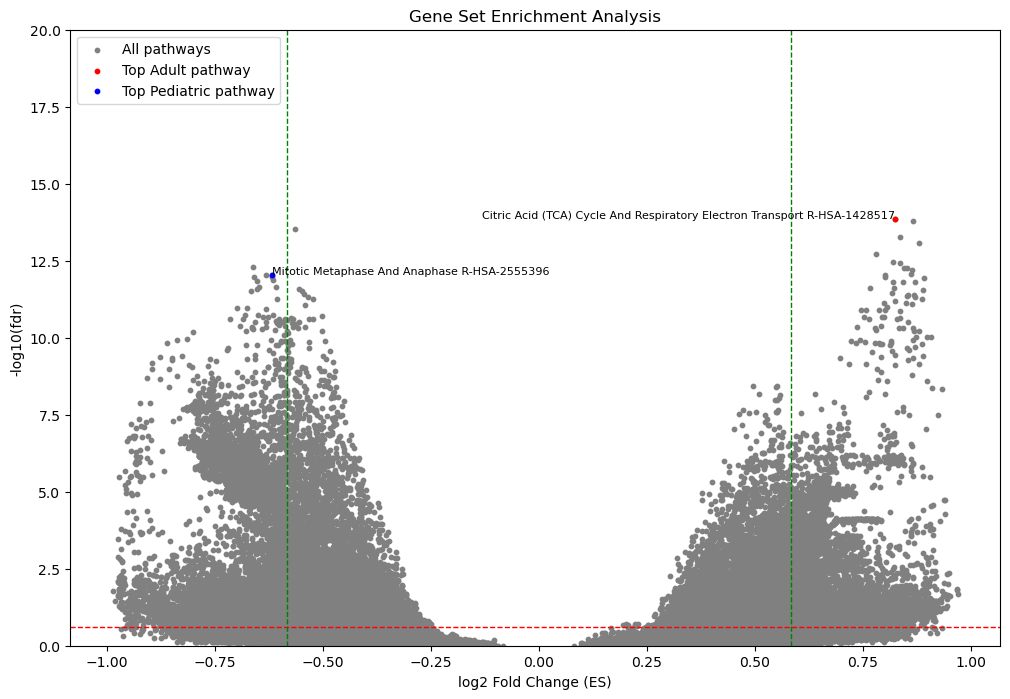

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

# Merge GSEA results with ANOVA results based on the 'Pathway' column
significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)
merged_df = significant_gsea_df.merge(significant_anova_results_df[['Term', 'Higher in', 'F-statistic']], on='Term', how='left')

# Define masks for adult and pediatric pathways
adult_mask = merged_df['Higher in'] == 'Adult'
pediatric_mask = merged_df['Higher in'] == 'Pediatric'

# Sort by the absolute value of NES and select the top 5 adult and top 5 pediatric pathways
top_adult = merged_df[adult_mask].loc[merged_df[adult_mask]['nes'].abs().nlargest(1).index]
top_pediatric = merged_df[pediatric_mask].loc[merged_df[pediatric_mask]['nes'].abs().nlargest(1).index]

# Combine the top pathways
top_pathways_df = pd.concat([top_adult, top_pediatric])

# Create the plot
plt.figure(figsize=(12, 8))

# Plot all pathways in grey
plt.scatter(x=all_GSEA_results_df['es'], 
            y=all_GSEA_results_df['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='grey', label='All pathways')

# Plot top adult pathways in red
plt.scatter(x=top_adult['es'], 
            y=top_adult['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='red', label='Top Adult pathway')

# Plot top pediatric pathways in blue
plt.scatter(x=top_pediatric['es'], 
            y=top_pediatric['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='blue', label='Top Pediatric pathway')

# Add LFC and FDR cut-off lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)

# Add labels for the top pathways

for i in top_pathways_df.index:
    es_value = top_pathways_df.at[i, 'es']
    fdr_value = top_pathways_df.at[i, 'fdr']
    pathway_label = top_pathways_df.at[i, 'Term']
    
    # Add the label for each point
    plt.text((es_value), (-np.log10(fdr_value)), pathway_label, fontsize=8, ha='right' if es_value > 0 else 'left')


# Label axes and add title
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0, 20)
plt.title('Gene Set Enrichment Analysis')

# Add legend
plt.legend()

# Save the figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea_top_labeled.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)

# Show the plot
plt.show()
